In [27]:
from torch import nn
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
from numpy import loadtxt
from PIL import Image
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

### Part 1, results:

First linear layer
- At-least-1-positive@1   : 0.141
- At-least-1-positive@5   : 0.354
- At-least-1-positive@10  : 0.453

First ReLU
- At-least-1-positive@1   : 0.159
- At-least-1-positive@5   : 0.366
- At-least-1-positive@10  : 0.468

Second linear
- At-least-1-positive@1   : 0.150
- At-least-1-positive@5   : 0.344
- At-least-1-positive@10  : 0.458

Second ReLU
- At-least-1-positive@1   : 0.160
- At-least-1-positive@5   : 0.365
- At-least-1-positive@10  : 0.477

Last linear
- At-least-1-positive@1   : 0.131
- At-least-1-positive@5   : 0.333
- At-least-1-positive@10  : 0.446

### Part 2

EmbNetGP, avg pool. size = 3, Stride=3
- At-least-1-positive@1   : 0.120
- At-least-1-positive@5   : 0.269
- At-least-1-positive@10  : 0.378

EmbNetGP, max pool. size = 3, Stride=3
- At-least-1-positive@1   : 0.156
- At-least-1-positive@5   : 0.347
- At-least-1-positive@10  : 0.463

0


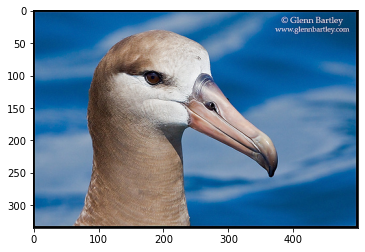

25


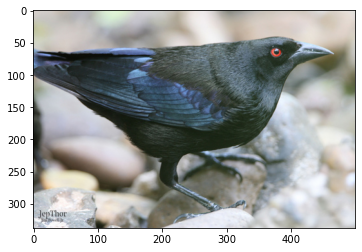

In [2]:
def cub_subset(n = 4):
    """
    Function to read subset of birds dataset CUB_200_2011
    n : n images per class
    """
    cub_folder = 'vs3ex1data/CUB_200_2011/'
    f = open(cub_folder + "images.txt", 'r')
    cub_imgfn = [a.split(' ')[::-1] for a in f.read().split('\n')]
    cub_label = loadtxt(cub_folder + "image_class_labels.txt", delimiter=" ", unpack=False)[:,1].astype(int) - 1
    sub_idx = []
    for i in range(0,max(cub_label)+1):
        sub_idx = sub_idx + ([x for (x,val) in enumerate(cub_label) if val == i][0:n])
        
    cub_img = [(cub_folder+'/jpg/'+cub_imgfn[x][0]) for x in sub_idx]
    cub_label = np.array([cub_label[x] for x in sub_idx])
    
    return cub_img, cub_label


# get images and labels for CUB subset
cub_img, cub_label = cub_subset()

# show sample images
for i in range(0,200,100):
    print(cub_label[i])
    plt.imshow(Image.open(cub_img[i]))
    plt.show
    plt.pause(0.1)

In [23]:
def l2n(x, eps=1e-6):
    """
    Vector L2 normalization 
    """
    return x / (torch.norm(x, p=2, dim=1, keepdim=True) + eps).expand_as(x)

class EmbNet(nn.Module):
    """
    Create network that maps an image to an embedding (descriptor) 
    """    
    def __init__(self, input_net, n = 3):
        """
        Contructor takes another network (input_net) as input
        input_net: assumed to have features and classifier fields (eg AlexNet, VGG, ...)
        n: keep unitl n-th layer of the classifier 
        """
        super(EmbNet, self).__init__()
        self.features = input_net.features
        self.classifier = nn.Sequential(*list(input_net.classifier[0:n+1]));  # keep until n-th layer

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))
        x = self.classifier(x)
        return l2n(x)

alexnet = torchvision.models.alexnet(pretrained = True) # load pre-trained model
# print(alexnet)
print(alexnet.classifier)

# image transformation 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
scale = transforms.Resize([224,224])
tote = transforms.ToTensor()
comptran = transforms.Compose([scale,tote,normalize])

last_layer = 1  # of the classifier part


for last_layer in range(1, 7):
    getdescriptor = EmbNet(alexnet, last_layer) # construct the network that extracts descriptors 
    getdescriptor.eval()   # put network in evaluation mode
    # print(getdescriptor)

    # extact descriptors for all images
    print('Extracting descriptors...')
    des = torch.Tensor()

    for i in range(0, len(cub_img)):
        with torch.no_grad():
            des = torch.cat((des, getdescriptor((comptran(Image.open(cub_img[i])).unsqueeze(0)))))

    # with torch.no_grad():
    #     des = torch.cat((des, getdescriptor((comptran(Image.open(cub_img[0])).unsqueeze(0)))))
    print(f"Layers: {last_layer}")
    test(des, cub_label)


Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Extracting descriptors...
Layers: 1
At-least-1-positive@1   : 0.141
At-least-1-positive@5   : 0.354
At-least-1-positive@10  : 0.453
Extracting descriptors...
Layers: 2
At-least-1-positive@1   : 0.159
At-least-1-positive@5   : 0.366
At-least-1-positive@10  : 0.468
Extracting descriptors...
Layers: 3
At-least-1-positive@1   : 0.159
At-least-1-positive@5   : 0.366
At-least-1-positive@10  : 0.468
Extracting descriptors...
Layers: 4
At-least-1-positive@1   : 0.150
At-least-1-positive@5   : 0.344
At-least-1-positive@10  : 0.458
Extracting descriptors...
Layers: 5
At-least-1-positive@1   : 0.160
At-least-1-positive@5   : 0.365
At-least-1-positive@10  : 0.477
Extracting des

In [26]:
def test(descriptors, labels):
    """
    Evaluate descriptors on retrieval
    """
    # compute all pair-wise distances
    cdistances = cdist(descriptors.data.numpy(), descriptors.data.numpy(), 'euclidean')

    # find rank of closest positive image (using each descriptor as a query)
    minrank_positive = []
    for i in range(0,len(cdistances)):
        idx = np.argsort(cdistances[i])
        minrank_positive.append( np.min([j for (j,x) in enumerate(labels[idx[1:-1]]) if x==labels[i]]) )

    print('At-least-1-positive@1   : {:.3f}'.format((np.array(minrank_positive)<1).mean()))
    print('At-least-1-positive@5   : {:.3f}'.format((np.array(minrank_positive)<5).mean()))
    print('At-least-1-positive@10  : {:.3f}'.format((np.array(minrank_positive)<10).mean()))

# evaluate the descriptors in a retrieval task 
# test(des, cub_label)

In [30]:
import torch.nn.functional as F


class EmbNetGP(nn.Module):
    """
    Create network that maps an image to an embedding (descriptor) with global pooling
    """    
    def __init__(self, input_net):
        """
        Contructor takes another network (input_net) as input
        input_net: assumed to have features and classifier fields (eg AlexNet, VGG, ...)
        n: keep unitl n-th layer of the classifier 
        """
        super(EmbNetGP, self).__init__()
        self.features = input_net.features
        self.avg_pool = torch.nn.MaxPool2d(6, stride=1)

    def forward(self, x):
        x = self.features(x)
        x = F.avg_pool2d(x, 3, stride=3)
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

        return l2n(x)



alexnet = torchvision.models.alexnet(pretrained = True) # load pre-trained model
# print(alexnet)

getdescriptor = EmbNetGP(alexnet) # construct the network that extracts descriptors 
getdescriptor.eval()   # put network in evaluation mode

new = getdescriptor((comptran(Image.open(cub_img[0])).unsqueeze(0)))
new = new.reshape((new.shape[1],))

# extact descriptors for all images
print('Extracting descriptors...')
des = torch.Tensor()
for i in range(0, len(cub_img)):
    with torch.no_grad():
        new = getdescriptor((comptran(Image.open(cub_img[i])).unsqueeze(0)))
        # new = new.reshape((new.shape[1],))
        # new.shape
        des = torch.cat((des, new))
print('Finished with extracting descriptors...')
# evaluate the descriptors in a retrieval task 
des = des.reshape(des.shape[:2])


Extracting descriptors...
Finished with extracting descriptors...


In [31]:
test(des, cub_label)

At-least-1-positive@1   : 0.120
At-least-1-positive@5   : 0.269
At-least-1-positive@10  : 0.378


In [32]:
import torch.nn.functional as F


class EmbNetGP(nn.Module):
    """
    Create network that maps an image to an embedding (descriptor) with global pooling
    """    
    def __init__(self, input_net):
        """
        Contructor takes another network (input_net) as input
        input_net: assumed to have features and classifier fields (eg AlexNet, VGG, ...)
        n: keep unitl n-th layer of the classifier 
        """
        super(EmbNetGP, self).__init__()
        self.features = input_net.features
        self.avg_pool = torch.nn.MaxPool2d(6, stride=1)

    def forward(self, x):
        x = self.features(x)
        x = F.max_pool2d(x, 3, stride=3)
        x = x.view(x.size(0), x.size(1)*x.size(2)*x.size(3))

        return l2n(x)



alexnet = torchvision.models.alexnet(pretrained = True) # load pre-trained model
# print(alexnet)

getdescriptor = EmbNetGP(alexnet) # construct the network that extracts descriptors 
getdescriptor.eval()   # put network in evaluation mode

new = getdescriptor((comptran(Image.open(cub_img[0])).unsqueeze(0)))
new = new.reshape((new.shape[1],))

# extact descriptors for all images
print('Extracting descriptors...')
des = torch.Tensor()
for i in range(0, len(cub_img)):
    with torch.no_grad():
        new = getdescriptor((comptran(Image.open(cub_img[i])).unsqueeze(0)))
        # new = new.reshape((new.shape[1],))
        # new.shape
        des = torch.cat((des, new))
print('Finished with extracting descriptors...')
# evaluate the descriptors in a retrieval task 
des = des.reshape(des.shape[:2])


Extracting descriptors...
Finished with extracting descriptors...


In [33]:
test(des, cub_label)

At-least-1-positive@1   : 0.156
At-least-1-positive@5   : 0.347
At-least-1-positive@10  : 0.463
